In [1]:
import sys
import os
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [2]:
feature_stand_path = "E:/mesa/features/acc_hrv_combine/"
feature_path = "E:/mesa/features/acc_hrv_no_stand/"
all_feature_names = "E:/mesa/feature_list.csv"

expriment_sample_id_file = "E:/mesa/expriment_samples.txt"


In [3]:
all_feature = pd.read_csv(all_feature_names)
all_feature_list = all_feature["feature_list"].tolist()

hrv_feature_names = ["mean_nni","sdnn","sdsd","nni_50","pnni_50","nni_20","pnni_20","rmssd","median_nni","range_nni","cvsd","cvnni","mean_hr",
                     "max_hr","min_hr", "std_hr","lf","hf","lf_hf_ratio","lfnu","hfnu","total_power","vlf","sd1", "sd2","ratio_sd2_sd1","csi",
                     "cvi","Modified_csi", "triangular_index"]
acc_feature_names = [x for x in all_feature_list if x not in hrv_feature_names]
#print(len(acc_feature_names))

In [4]:
sample_id_list =[]
with open(expriment_sample_id_file) as f:
    for line in f:
        sample_id_list.append(line.strip())
all_df_list = []
for sample_id in sample_id_list:
    features_df = pd.read_csv(os.path.join(feature_stand_path,(sample_id+'_combined.csv')))
    #hrv_feature_df = hrv_feature_df.iloc[:, :30]
    all_df_list.append(features_df)
    
all_feature_df_100 = pd.concat(all_df_list)
#all_feature_df_100 = all_feature_df_100.astype(float)

hrv_feature_df = all_feature_df_100[hrv_feature_names].astype(float)
acc_feature_df = all_feature_df_100[acc_feature_names].astype(float)

acc_hrv_feature_df = result = pd.concat([hrv_feature_df, acc_feature_df], axis=1)

print(acc_hrv_feature_df.shape[0])
acc_hrv_feature_df.head()
    

112296


,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,_max_19,_min_19,_std_19,_var_19,_nat_19,_anyact_19,_skew_19,_kurt_19,_LocAct,_Act
0,0.249651,0.216277,0.135700,-0.294067,-0.206015,0.819195,0.528122,0.118448,0.284218,0.018287,...,-0.195332,-0.198826,-0.038488,-0.295203,-0.427804,1.031324,-0.477505,-0.990373,2.035594,0.481718
1,0.078485,-0.069824,-0.232090,-0.294067,-0.206015,-0.429460,-0.314812,-0.212356,0.094822,-0.097670,...,-0.195332,-0.198826,-0.036056,-0.294490,-0.427804,0.818357,-0.475801,-0.990421,-0.409030,-0.300638
2,0.129879,-0.198571,-0.131532,-0.294067,-0.206015,-0.429460,-0.314812,-0.129096,0.142171,-0.279063,...,-0.195332,-0.198826,-0.036056,-0.294490,-0.427804,0.818357,-0.475801,-0.990421,-0.409030,-0.300638
3,0.255071,-0.320846,-0.221557,-0.294067,-0.206015,-0.429460,-0.314812,-0.208651,0.284218,-0.369759,...,-0.195332,-0.198826,-0.036959,-0.294756,-0.427804,1.031324,-0.475645,-0.990169,0.036106,-0.282857
4,0.219076,-0.395855,-0.202124,-0.294067,-0.206015,-0.429460,-0.314812,-0.192924,0.236869,-0.505803,...,-0.195332,-0.198826,-0.060079,-0.301386,-0.427804,0.818357,-0.269916,-0.830808,-0.409030,-0.300638


In [5]:
# all_feature_without_null = all_hrv_df.drop("tinn", axis=1)
# all_feature_without_null = all_feature_without_null.astype(np.float32)
# all_feature_without_null.replace([np.nan, np.inf, -np.inf], np.nan, inplace=True)
# all_feature_without_null = all_feature_without_null.dropna()
#all_feature_without_null.head()

PSG_stages = all_feature_df_100["stages"].to_list()

Y_PSG_2class = []#0=weak,1=sleep
Y_PSG_3class = []#0=weak,1,2,3=NREM=1,5=REM=2
Y_PSG_4class = []#0=weak,1/2=light sleep=1, 3=deep sleep=2,4=REM=3
Y_PSG_5class = PSG_stages
for stage in PSG_stages:
    if stage == 0:
        Y_PSG_2class.append(0)
        Y_PSG_3class.append(0)
        Y_PSG_4class.append(0)
    elif stage == 1:
        Y_PSG_2class.append(1)
        Y_PSG_3class.append(1)
        Y_PSG_4class.append(1)
    elif stage == 2:
        Y_PSG_2class.append(1)
        Y_PSG_3class.append(1)
        Y_PSG_4class.append(1)
    elif stage == 3:
        Y_PSG_2class.append(1)
        Y_PSG_3class.append(1)
        Y_PSG_4class.append(2)
    elif stage == 4:
        Y_PSG_2class.append(1)
        Y_PSG_3class.append(2)
        Y_PSG_4class.append(3)

print(set(Y_PSG_2class),set(Y_PSG_3class),set(Y_PSG_4class),set(Y_PSG_5class))

{0, 1} {0, 1, 2} {0, 1, 2, 3} {0, 1, 2, 3, 4}


In [6]:
# has_null_values = X_hrv_feature.isnull().values.any()
# print(has_null_values)
# # null_mask = X_hrv_feature.isnull()
# # # print(null_mask.any(axis=1))
# # # print(null_mask.any(axis=0))
# # print(X_hrv_feature.isnull().sum())
# X_hrv_feature_without_null = X_hrv_feature.dropna()
# print(X_hrv_feature_without_null.isnull().values.any())
# X_hrv_feature.replace('inf', np.inf, inplace=True)
# clean_df = X_hrv_feature.dropna()
# has_infinity = np.isinf(X_hrv_feature.values).any()
# print(has_infinity)



# 检查是否存在无穷大的值
has_infinity = np.isinf(acc_feature_df).any()
print(has_infinity)
has_nan = np.isnan(acc_feature_df).any()
print(has_nan)


_mean_centered_1      False
_median_centered_1    False
_max_centered_1       False
_min_centered_1       False
_std_centered_1       False
                      ...  
_anyact_19            False
_skew_19              False
_kurt_19              False
_LocAct               False
_Act                  False
Length: 370, dtype: bool
_mean_centered_1      False
_median_centered_1    False
_max_centered_1       False
_min_centered_1       False
_std_centered_1       False
                      ...  
_anyact_19            False
_skew_19              False
_kurt_19              False
_LocAct               False
_Act                  False
Length: 370, dtype: bool


In [7]:
def draw_cof_martix(y_PSG_stages_label,y_PSG_stages_pred):   

    conf_martix = confusion_matrix(y_PSG_stages_label,y_PSG_stages_pred)

    # 打印混淆矩阵
    print("hrv feature 2 classification Confusion Matrix:")
    print(conf_martix)

    # 计算每个类别的总数
    class_totals = np.sum(conf_martix, axis=1)
    class_names = np.unique(y_PSG_stages_label)

    # 计算每个单元格的百分比
    cell_percentages = conf_martix / class_totals[:, np.newaxis]
    cell_numbers = conf_martix

    # 绘制混淆矩阵热图
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cell_percentages,annot=False, cmap='Blues', fmt='.2%', xticklabels= class_names, yticklabels= class_names)
    

    for i in range(len( class_names)):
        for j in range(len(class_names)):
            ax.text(j + 0.5, i + 0.5, f'{cell_percentages[i, j]:.2%}\n{cell_numbers[i, j]}',
                ha='center', va='center', color='black')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.show()

In [8]:
def run_ml_model(features,lables,model,parameters,model_name,feature_class):
    feature_train, feature_test, labels_train, lables_test = train_test_split(features, lables, test_size=0.2, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=parameters,n_jobs=4, cv=5, scoring="accuracy", verbose=1, pre_dispatch=10)
    grid_search.fit(feature_train, labels_train)
    print("Best Parameters: %s, Best Score: %s "%(grid_search.best_params_,grid_search.best_score_))

    best_model = grid_search.best_estimator_
    best_model.fit(feature_train, labels_train)
    pred_labels = best_model.predict(feature_test)

    Accuracy = accuracy_score(lables_test , pred_labels)
    F1_score = f1_score(lables_test , pred_labels, average='macro')
    print("Accuracy: %s, F1 Score: %s "%(Accuracy,F1_score))
    
    draw_cof_martix(lables_test , pred_labels)
    with open("./models/" + "%d_stages_%s_%s_.pkl" % (len(set(lables)), model_name, feature_class), "wb") as f:
        pickle.dump(best_model, f)

### Only hrv features Random Forest

In [9]:
#hrv_feature_train, X_hrv_feature_test, y_PSG_stages_train, y_PSG_stages_test = train_test_split(X_hrv_feature, Y_PSG_stages_2class, test_size=0.2, random_state=42)
RF_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto']
}

rf = RandomForestClassifier(n_jobs=5, max_features='sqrt', n_estimators=300, oob_score=True)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_features': 'auto', 'n_estimators': 200}, Best Score: 0.8092969556187928 
Accuracy: 0.8136242208370437, F1 Score: 0.7835331368347096 
hrv feature 2 classification Confusion Matrix:
[[ 4950  3076]
 [ 1110 13324]]


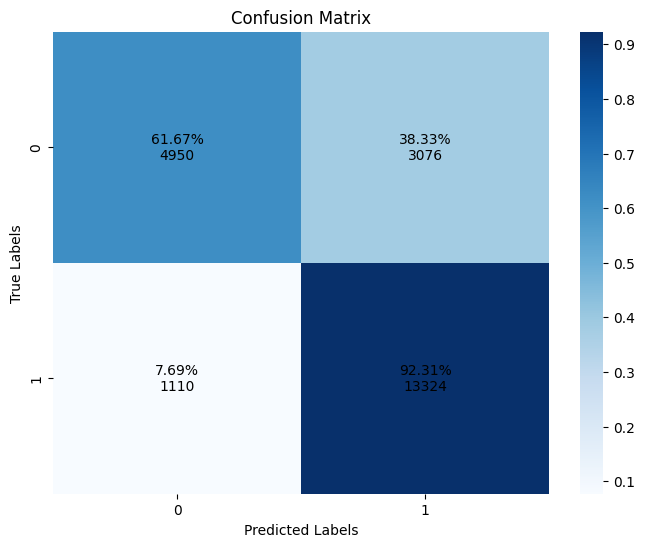

In [10]:

run_ml_model(hrv_feature_df,Y_PSG_2class,rf,RF_param_grid,"Random Forest","HRV")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_features': 'auto', 'n_estimators': 300}, Best Score: 0.7307872437154869 
Accuracy: 0.7365983971504898, F1 Score: 0.5806669277838793 
hrv feature 2 classification Confusion Matrix:
[[ 5414  2551    61]
 [ 1088 10806    86]
 [  583  1547   324]]


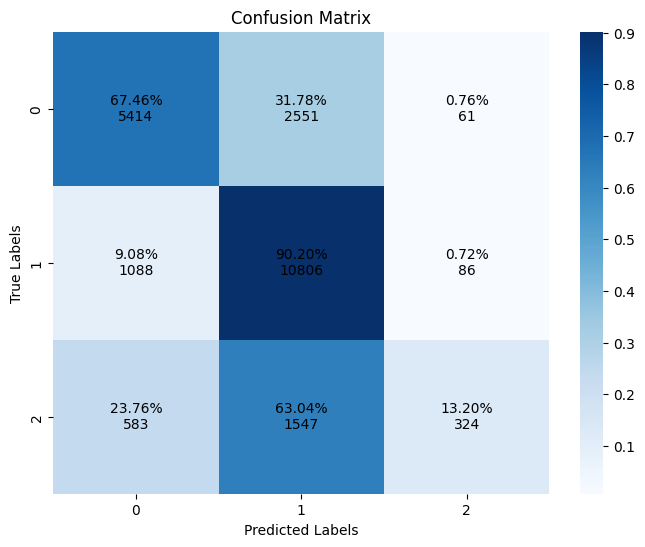

In [25]:
run_ml_model(hrv_feature_df,Y_PSG_3class,rf,RF_param_grid,"Random Forest","HRV")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_features': 'auto', 'n_estimators': 300}, Best Score: 0.678937199276144 
Accuracy: 0.6825022261798753, F1 Score: 0.49013384857356784 
hrv feature 2 classification Confusion Matrix:
[[5587 2348   17   74]
 [1139 9145   85  104]
 [ 160 1091  241   15]
 [ 635 1447   16  356]]


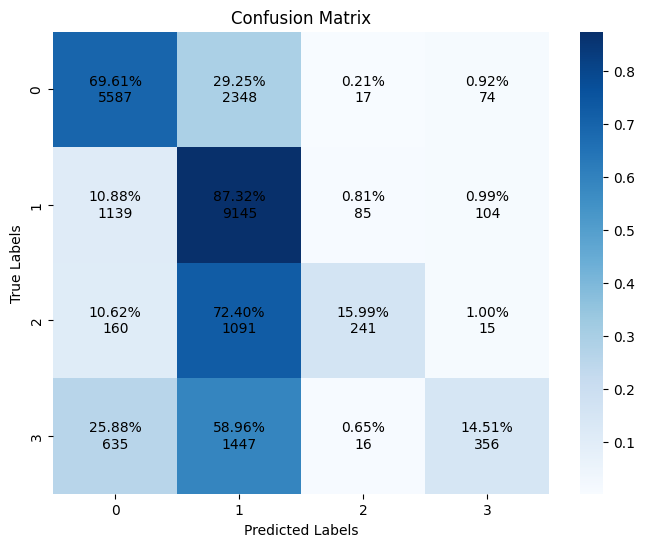

In [26]:
run_ml_model(hrv_feature_df,Y_PSG_4class,rf,RF_param_grid,"Random Forest","HRV")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_features': 'auto', 'n_estimators': 300}, Best Score: 0.6194955425849736 
Accuracy: 0.6201691896705254, F1 Score: 0.39496371817948084 
hrv feature 2 classification Confusion Matrix:
[[6018   25 1883   15   85]
 [ 479   47 1337    8   43]
 [1119   37 7208   85  110]
 [ 208    1 1021  252   25]
 [ 764   10 1258   18  404]]


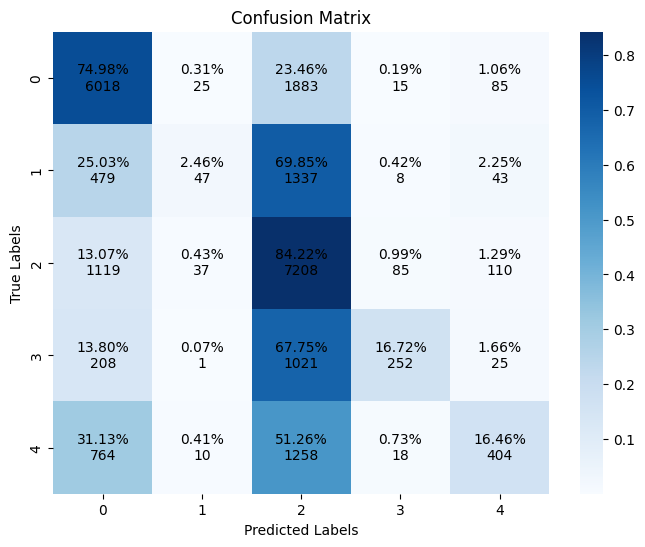

In [27]:
run_ml_model(hrv_feature_df,Y_PSG_5class,rf,RF_param_grid,"Random Forest","HRV")

## Acihraphy Expriments

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_features': 'auto', 'n_estimators': 300}, Best Score: 0.908388604967423 
Accuracy: 0.9167853962600178, F1 Score: 0.90788643393848 
hrv feature 2 classification Confusion Matrix:
[[ 6805  1221]
 [  648 13786]]


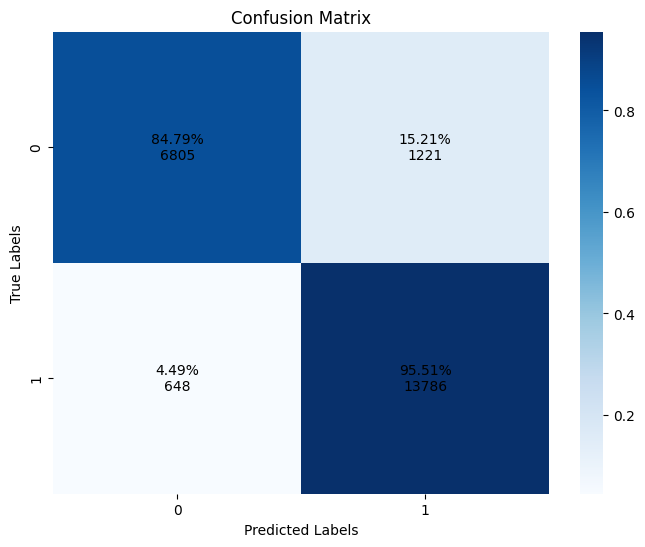

In [13]:
run_ml_model(acc_feature_df,Y_PSG_2class,rf,RF_param_grid,"Random Forest","ACC")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_features': 'auto', 'n_estimators': 300}, Best Score: 0.8430250421756202 
Accuracy: 0.8561442564559216, F1 Score: 0.7949008510050087 
hrv feature 2 classification Confusion Matrix:
[[ 6903  1040    83]
 [  677 11052   251]
 [  120  1060  1274]]


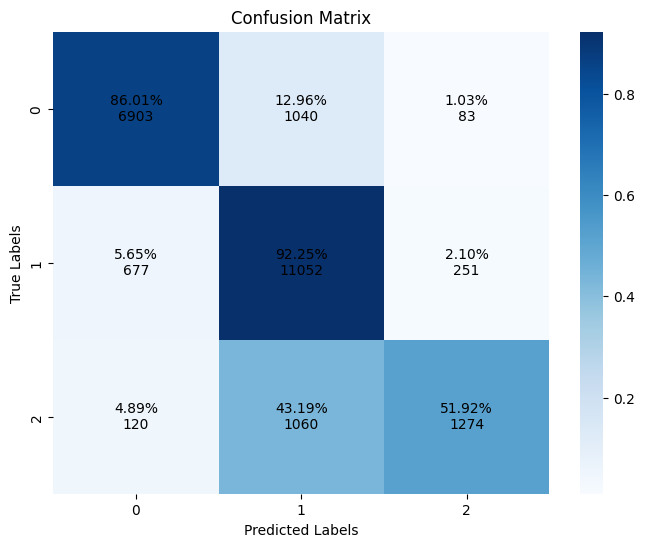

In [14]:
run_ml_model(acc_feature_df,Y_PSG_3class,rf,RF_param_grid,"Random Forest","ACC")

In [67]:
hrv_best_RF_model = best_model
hrv_best_RF_model.fit(hrv_feature_train, y_PSG_stages_train)

# 在测试集上进行预测
y_hrv_PSG_pred_2calss = hrv_best_RF_model.predict(X_hrv_feature_test)

# 计算准确率和F1得分
hrv_accuracy_2class = accuracy_score(y_PSG_stages_test, y_hrv_PSG_pred_2calss )
hrv_f1_2class = f1_score(y_PSG_stages_test, y_hrv_PSG_pred_2calss )

# 打印准确率和F1得分
print("Accuracy: ", hrv_accuracy_2class)
print("F1 Score: ", hrv_f1_2class)

Accuracy:  0.7292794474519321
F1 Score:  0.8116864145430938


hrv feature 2 classification Confusion Matrix:
[[ 3125  4451]
 [ 1350 12502]]


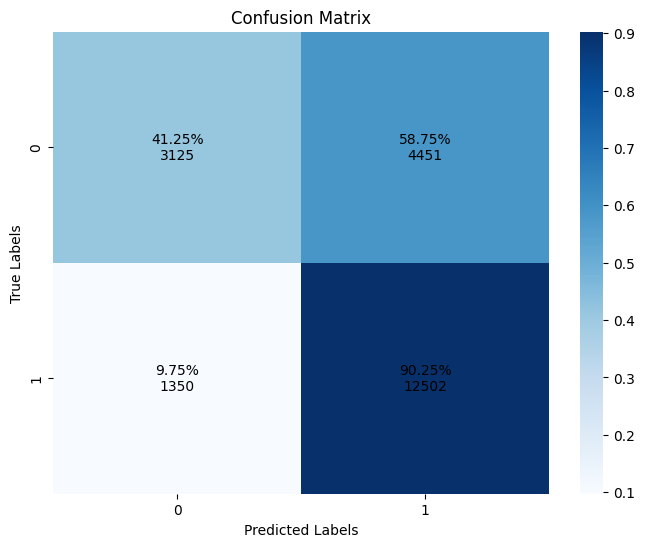

In [107]:
draw_cof_martix(y_PSG_stages_test, y_hrv_PSG_pred_2calss)

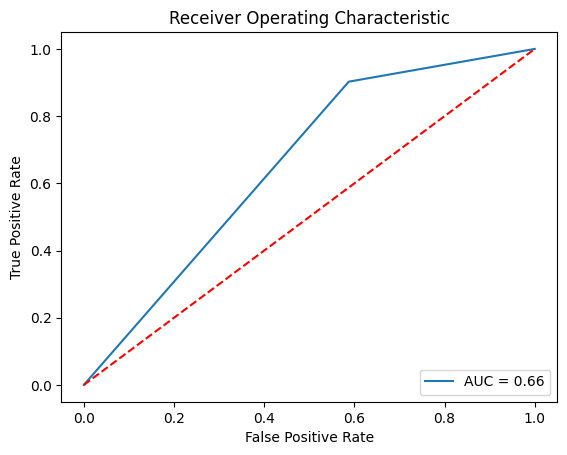

In [69]:
# 计算ROC曲线的假正例率（FPR）、真正例率（TPR）和阈值（thresholds）
hrv_fpr_2class, hrv_tpr_2class, hrv_thresholds_2class = roc_curve(y_PSG_stages_test, y_hrv_PSG_pred_2calss)

# 计算AUC值
auc_score = auc(hrv_fpr_2class, hrv_tpr_2class)

# 绘制ROC曲线
plt.plot(hrv_fpr_2class, hrv_tpr_2class, label='AUC = %0.2f' % auc_score)
plt.plot([0, 1], [0, 1], 'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [103]:
X_hrv_feature_train_3class, X_hrv_feature_test_3class, y_PSG_stages_train_3class, y_PSG_stages_test_3class = train_test_split(X_hrv_feature, Y_PSG_stages_3class, test_size=0.2, random_state=42)

Accuracy:  0.6399570655217472
F1 Score:  0.5959254130100676
hrv feature 2 classification Confusion Matrix:
[[3657 3871   48]
 [1417 9980   38]
 [ 575 1766   76]]


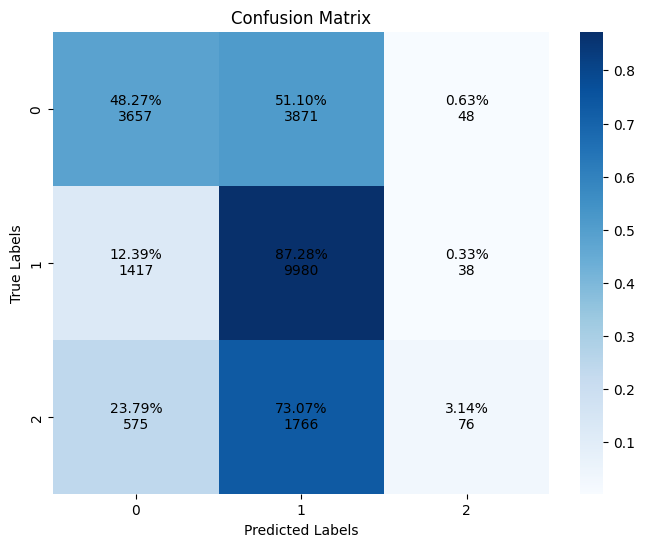

In [109]:
hrv_3class_rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, criterion='gini')
hrv_3class_rf_model.fit(X_hrv_feature_train_3class,y_PSG_stages_train_3class)
hrv_rf_3class_pred = hrv_3class_rf_model.predict(X_hrv_feature_test_3class)

hrv_accuracy_rf_3class = accuracy_score(y_PSG_stages_test_3class , hrv_rf_3class_pred )
hrv_f1_rf_3class = f1_score(y_PSG_stages_test_3class , hrv_rf_3class_pred, average='weighted')

# 打印准确率和F1得分
print("Accuracy: ", hrv_accuracy_rf_3class)
print("F1 Score: ", hrv_f1_rf_3class)
draw_cof_martix(y_PSG_stages_test_3class,hrv_rf_3class_pred)


Accuracy:  0.5201138697031921
F1 Score:  0.4584881353331885
hrv feature 2 classification Confusion Matrix:
[[4611   25 2837   20   83]
 [ 673   28 1167    6   26]
 [1577   30 6221   82   72]
 [ 285    2 1087  158   21]
 [ 890   12 1378   10  127]]


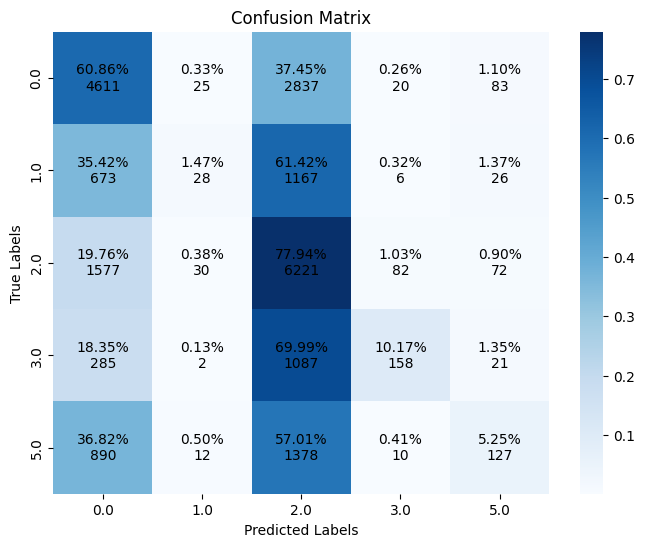

In [111]:
X_hrv_feature_train_5class, X_hrv_feature_test_5class, y_PSG_stages_train_5class, y_PSG_stages_test_5class = train_test_split(X_hrv_feature, Y_PSG_stages, test_size=0.2, random_state=42)
hrv_5class_rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, criterion='gini')

hrv_5class_rf_model.fit(X_hrv_feature_train_5class,y_PSG_stages_train_5class)
hrv_rf_5class_pred = hrv_5class_rf_model.predict(X_hrv_feature_test_5class)

hrv_accuracy_rf_5class = accuracy_score(y_PSG_stages_test_5class , hrv_rf_5class_pred )
hrv_f1_rf_5class = f1_score(y_PSG_stages_test_5class , hrv_rf_5class_pred, average='weighted')

# 打印准确率和F1得分
print("Accuracy: ", hrv_accuracy_rf_5class)
print("F1 Score: ", hrv_f1_rf_5class)
draw_cof_martix(y_PSG_stages_test_5class,hrv_rf_5class_pred)



### Only hrv features SVM

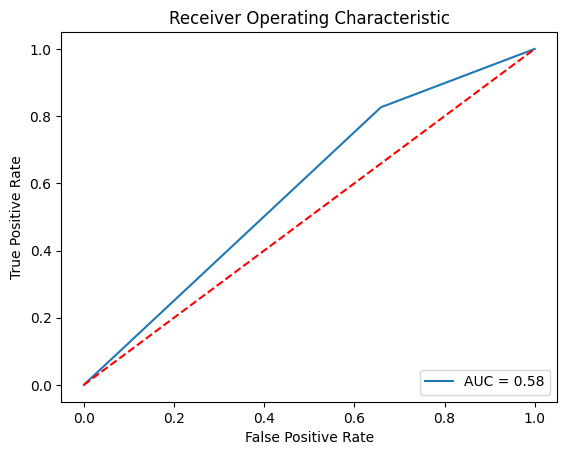

In [127]:
# 计算ROC曲线的假正例率（FPR）、真正例率（TPR）和阈值（thresholds）
hrv_fpr_2class, hrv_tpr_2class, hrv_thresholds_2class = roc_curve(y_PSG_stages_test_2class , hrv_2class_svm_pred)

# 计算AUC值
auc_score = auc(hrv_fpr_2class, hrv_tpr_2class)

# 绘制ROC曲线
plt.plot(hrv_fpr_2class, hrv_tpr_2class, label='AUC = %0.2f' % auc_score)
plt.plot([0, 1], [0, 1], 'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

e:\virual_env\CS909\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy:  0.5684151577375397
F1 Score:  0.5128487836046689
hrv feature 2 classification Confusion Matrix:
[[2584 4992    0]
 [1839 9596    0]
 [ 566 1851    0]]


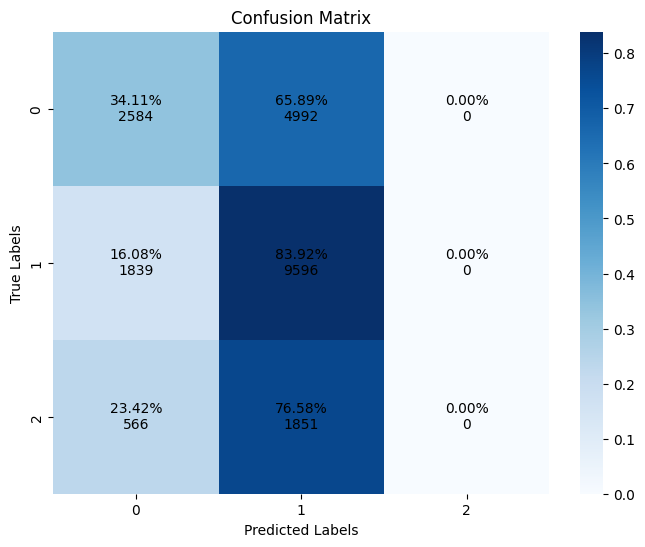

In [130]:
X_hrv_feature_train_3class, X_hrv_feature_test_3class, y_PSG_stages_train_3class, y_PSG_stages_test_3class = train_test_split(X_hrv_feature, Y_PSG_stages_3class, test_size=0.2, random_state=42)
hrv_3class_svm_model = LinearSVC(C=1.e-3, loss='squared_hinge', penalty='l2', dual=True,
                      fit_intercept=True, max_iter=1000)

hrv_3class_svm_model.fit(X_hrv_feature_train_3class,y_PSG_stages_train_3class)
hrv_3class_svm_pred = hrv_2class_svm_model.predict(X_hrv_feature_test_3class)

hrv_accuracy_3class_svm = accuracy_score(y_PSG_stages_test_3class , hrv_3class_svm_pred )
hrv_f1_3class_svm = f1_score(y_PSG_stages_test_3class , hrv_3class_svm_pred, average='weighted')

# 打印准确率和F1得分
print("Accuracy: ", hrv_accuracy_3class_svm)
print("F1 Score: ", hrv_f1_3class_svm)
draw_cof_martix(y_PSG_stages_test_3class , hrv_3class_svm_pred )

### Only actigraphy Random Forest

In [113]:
all_acc_df_list =[]
for overlap_id in random_sample_ids:
    acc_feature_df = pd.read_csv(os.path.join(actigraphy_feature_output_path,(overlap_id+'_act_features.csv')))
    acc_feature_df = acc_feature_df.drop(acc_filiter_names, axis=1)
    all_acc_df_list.append(acc_feature_df)
all_acc_df = pd.concat(all_acc_df_list)

print(all_acc_df.shape[0])

all_acc_df.head()
    

112060


,_mean_1,_mean_centered_1,_median_1,_median_centered_1,_std_1,_std_centered_1,_max_1,_max_centered_1,_min_1,_min_centered_1,...,_nat_19,_nat_centered_19,_anyact_19,_anyact_centered_19,_skew_19,_skew_centered_19,_kurt_19,_kurt_centered_19,_Act,_LocAct
0,0.702302,0.702302,0.702302,0.702302,0.0,0.0,0.702302,0.702302,0.702302,0.702302,...,0.489302,0.915988,0.598129,0.735922,0.507745,-0.403433,0.323844,-0.694031,0.702302,1.133913
1,1.189234,1.189234,1.189234,1.189234,0.0,0.0,1.189234,1.189234,1.189234,1.189234,...,0.061143,0.915988,0.598129,0.735922,0.100427,-0.492689,-0.258083,-0.725747,1.189234,1.266411
2,0.795943,0.795943,0.795943,0.795943,0.0,0.0,0.795943,0.795943,0.795943,0.795943,...,0.061143,0.915988,0.736440,0.735922,-0.143945,-0.494117,-0.484451,-0.727554,0.795943,1.162768
3,1.254782,1.254782,1.254782,1.254782,0.0,0.0,1.254782,1.254782,1.254782,1.254782,...,-0.367016,0.915988,0.736440,0.735922,-0.333927,-0.731318,-0.688898,-0.918273,1.254782,1.281492
4,-0.018731,-0.018731,-0.018731,-0.018731,0.0,0.0,-0.018731,-0.018731,-0.018731,-0.018731,...,0.061143,0.915988,0.736440,0.735922,-0.366916,-0.684268,-0.695646,-0.842927,-0.018731,0.805090


In [119]:
all_hrv_df_list =[]
for overlap_id in random_sample_ids:
    hrv_feature_df = pd.read_csv(os.path.join(hrv_feature_output_path,(overlap_id+'_hrv_features.csv')))
    #hrv_feature_df = hrv_feature_df.iloc[:, :30]
    all_hrv_df_list.append(hrv_feature_df)
all_hrv_df = pd.concat(all_hrv_df_list)

print(all_hrv_df.shape[0])
all_hrv_df.head()

107307


,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,triangular_index,tinn,stages,mesaid,epoch
0,948.243039,47.003926,43.767696,5,16.129032,8,25.806452,44.117543,937.50000,292.986919,...,58.557713,1.861338,1.861338,4.469463,435.982738,4.571429,NaN,0,5606,1
1,981.476815,8.674323,13.031246,0,0.000000,2,6.666667,13.033848,984.37500,31.250000,...,7.915381,0.844577,0.844577,3.074424,26.740595,2.818182,NaN,0,5606,2
2,950.730847,20.364452,14.153832,0,0.000000,5,16.666667,14.192111,953.12500,70.312500,...,26.940720,2.646601,2.646601,3.642250,285.205388,5.166667,NaN,0,5606,3
3,993.825605,22.861280,16.804444,0,0.000000,6,20.000000,16.967100,988.28125,85.937500,...,29.986878,2.481193,2.481193,3.763322,297.612878,5.166667,NaN,0,5606,4
4,1007.543103,14.003902,18.217003,0,0.000000,7,25.000000,18.217537,1011.71875,58.593750,...,14.837230,1.131081,1.131081,3.493332,67.128443,2.636364,NaN,0,5606,5


In [115]:
all_acc_df = all_acc_df.astype(np.float32)
all_acc_df.replace([np.nan, np.inf, -np.inf], np.nan, inplace=True)
X_acc_features = all_acc_df.dropna()

In [116]:
has_infinity = np.isinf(X_acc_features.values).any()
print(has_infinity)
has_nan = np.isnan(X_acc_features.values).any()
print(has_nan)

False
False


In [117]:
X_acc_feature_train_2class, X_acc_feature_test_2calss, y_acc_stages_train_2class, y_PSG_stages_test_2class = train_test_split(X_acc_features, Y_PSG_stages_2class, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [112060, 107136]